<a href="https://colab.research.google.com/github/patrickjaigner/fastai-V1/blob/master/multi_label_image_classifier/Multi_Label_Image_Movie_Genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of the notebook is to download a database from the web and
learn how to use the fastai data block api to read in the dataset for the purpose of multi label classification.



In [9]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1022      0 --:--:-- --:--:-- --:--:--  1022
Updating fastai...
Done.


In [0]:
from fastai.vision import *
import pandas as pd

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [13]:
! ls gdrive/'My Drive'/datasets/Multi_Label_dataset/Multi_Label_dataset

Images	train.csv


In [0]:
base_path = os.path.join(root_dir, 'datasets/Multi_Label_dataset')
ds_path = os.path.join(base_path,'train.csv')

In [15]:
# Dataset: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html

!wget -P gdrive/'My Drive'/datasets/Multi_Label_dataset https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Dataset.zip

--2020-04-25 16:23:41--  https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Dataset.zip
Resolving www.cs.ccu.edu.tw (www.cs.ccu.edu.tw)... 140.123.101.3
Connecting to www.cs.ccu.edu.tw (www.cs.ccu.edu.tw)|140.123.101.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264902968 (253M) [application/zip]
Saving to: ‘gdrive/My Drive/datasets/Multi_Label_dataset/Movie_Poster_Dataset.zip’

Movie_Poster_Datase 100%[===================>] 252.63M  76.9MB/s    in 3.3s    

2020-04-25 16:23:44 (76.2 MB/s) - ‘gdrive/My Drive/datasets/Multi_Label_dataset/Movie_Poster_Dataset.zip’ saved [264902968/264902968]



In [0]:
!unzip gdrive/'My Drive'/datasets/Multi_Label_dataset/Multi_Label_dataset.zip -d gdrive/'My Drive'/datasets/

Streaming output truncated to the last 5000 lines.
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt2002718.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1735279.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1700845.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1682180.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1634003.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1538403.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1535108.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1453405.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt1327773.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt2905084.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt2367996.jpg  
  inflating: gdrive/My Drive/datasets/Multi_Label_dataset/

In [16]:
df = pd.read_csv(ds_path)
df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
a = '/content/gdrive/My Drive/datasets/Multi_Label_dataset/Images/tt0085549.jpg'
#a[-13:-4]

pat = r'/([^/]+).jpg$'
p = re.compile(pat)

p.findall(a)[0]

'tt0085549'

In [0]:
def label_from_df(x):
  pat = r'/([^/]+).jpg$'
  p = re.compile(pat)

  file_name = p.findall(x)[0]

  return df['Genre'].loc[df['Id'] == file_name].values[0][2:-2].replace("'","").replace(",","").split(' ')

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(base_path, 'train.csv', folder='Images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_func(label_from_df ))

In [0]:
tfms = get_transforms()
data = (src.transform(tfms, size=64)
        .databunch().normalize(imagenet_stats))


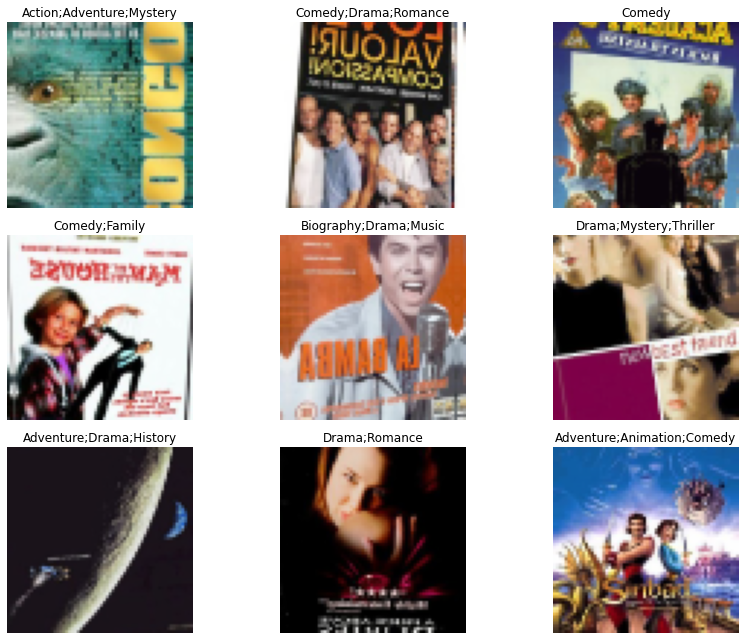

In [28]:
data.show_batch(rows=3, figsize=(12,9))

In [29]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Action',
  'Adventure',
  'Animation',
  'Biography',
  'Comedy',
  'Crime',
  'Documentary',
  'Drama',
  'Family',
  'Fantasy',
  'History',
  'Horror',
  'Music',
  'Musical',
  'Mystery',
  'N/A',
  'News',
  'Reality-TV',
  'Romance',
  'Sci-Fi',
  'Short',
  'Sport',
  'Thriller',
  'War',
  'Western'],
 25,
 5804,
 1450)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.778059,0.355971,0.546786,0.399167,23:57
1,0.351327,0.244504,0.883779,0.479936,00:47
2,0.266498,0.238513,0.882952,0.488782,00:43
3,0.247087,0.235467,0.882234,0.494428,00:43


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


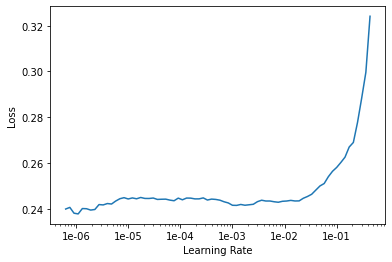

In [36]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.241152,0.233241,0.882814,0.500602,00:43
1,0.238121,0.231417,0.883448,0.502956,00:43
2,0.234754,0.229041,0.884028,0.513627,00:43
3,0.229724,0.228665,0.885407,0.517572,00:42
4,0.227666,0.228844,0.885324,0.520268,00:44


In [0]:
learn.save('stage-2')

In [0]:
# results from the paper: https://www.cs.ccu.edu.tw/~wtchu/papers/2017MUSA-chu.pdf
# accuracy is between 7-15%

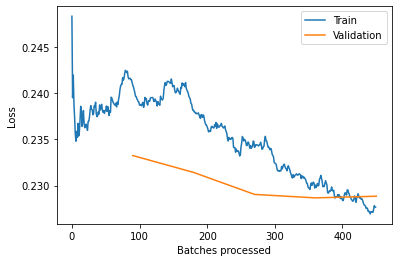

In [41]:
learn.recorder.plot_losses()